In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [57]:
import numpy as np
import pandas as pd
from pandas import Series
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from pipeline import Dataset
from datatools import data_quantization

In [8]:
dataset = Dataset.load('../../data/parsed')

In [11]:
# quantized data; set_index to separate index level
quantized_fundamental, _ = data_quantization(dataset.fundamental.set_index(['asset', 'day']))

In [22]:
full_df = pd.concat(
    [dataset.fundamental.set_index(['asset', 'day']), dataset.ref_return.set_index(['asset', 'day'])],
    axis=1).dropna()

In [23]:
# swap day and asset index, automatically sorted
df = full_df.swaplevel()
df.head()

turnoverRatio  transactionAmount    pe_ttm        pe      pb  \
day asset                                                                 
1   0             3.6794            17229.0   34.4425   32.3029  4.9425   
    1             2.5150             3706.0   28.9934   27.2726  5.0552   
    2             1.2858             5136.0   42.9352   41.9279  4.8083   
    3             2.2007             3280.0   15.2245   13.8032  2.1904   
    4             0.8627             5291.0 -369.9850 -433.1736  3.0714   

               ps       pcf    return  
day asset                              
1   0      3.8180 -578.7700 -0.026877  
    1      3.0484   23.8260 -0.052674  
    2      4.1392  -58.2185 -0.002691  
    3      0.6691   61.0491 -0.018515  
    4      2.9370  -25.2279 -0.019184

In [54]:
df['return'].iloc[[6,7,8,9,10]]

day  asset
1    6        0.018743
     7        0.014376
     8       -0.011925
     9       -0.020020
     10      -0.024798
Name: return, dtype: float64

In [65]:
# X = df[['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE', 'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']]
# X = df[['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']]
# y = df['return']

# original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']
original_feature = full_df.columns[:-1]
# quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE', 'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']
quantile_feautre = quantized_fundamental.columns

tscv = TimeSeriesSplit(n_splits=99)
test_prediction = Series(dtype=float)
test_reference = Series(dtype=float)
train_test_scores = []
for train, test in tqdm(tscv.split(df)):
    # train & test return indices of the time series splitting
    X, _ = data_quantization(df[original_feature])
    reg = LinearRegression().fit(X.iloc[train], df['return'].iloc[train])
    # score computes the coefficient of determination R^2.
    # best possible is 1; could be arbitrarily worse
    train_score = reg.score(X.iloc[train], df['return'].iloc[train])
    # train_score = X.iloc[train].corr(df['return'].iloc[train])
    test_prediction = pd.concat([test_prediction, Series(reg.predict(X.iloc[test]), index=X.index[test])])
    test_reference = pd.concat([test_reference, df['return'].iloc[test]])
    # test_score = r2_score(test_reference, test_prediction)
    test_score = test_reference.corr(test_prediction)
    # test_score = reg.score(X.iloc[test], y.iloc[test])
    train_test_scores.append((train_score, test_score))
    # print(f'train score: {train_score:.4f}, test score: {test_score:.4f}')

# final_model = LinearRegression().fit(X, y)

0it [00:00, ?it/s]

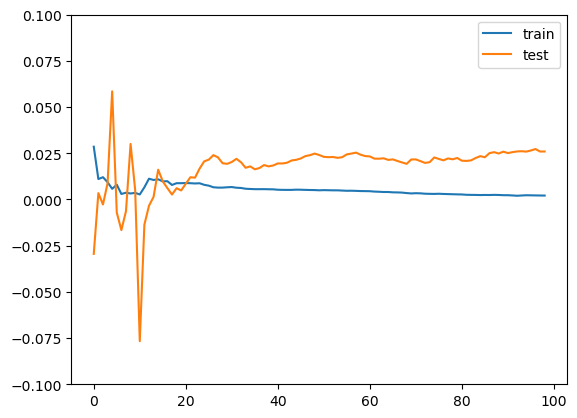

In [66]:
plt.figure(1)
plt.plot([_[0] for _ in train_test_scores], label='train')
plt.plot([_[1] for _ in train_test_scores], label='test')
plt.ylim([-0.1, 0.1])
plt.legend(loc='best')

